In [1]:
using(LinearAlgebra)
using(DataFrames)
using Plots
using CSV
using Statistics
using Polynomials
using NoveltyColors
using Pkg


(process:17288): GLib-GIO-WARNING **: 13:38:55.115: Unexpectedly, UWP app `Microsoft.ZuneVideo_10.22031.10071.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ZuneVideo_8wekyb3d8bbwe!Microsoft.ZuneVideo') supports 33 extensions but has no verbs


#### Zadanie 1 (1pkt)
Ustal losowe (referencyjne) x rozmiaru 1000 oraz losowe A rozmiaru 1000x1000, policz b=A*x.
Nastepnie rozwiąż równanie Ax=b trzema metodami:
- inv()
- \
- factorize()

Porównaj jakość wyniku (zmierzoną jako długość różnicy wektorów wyniku oraz referencyjnego x) oraz czas wykonania (@time). UWAGA: pierwsze wykonanie funkcji w Julii zawiera czas kompilacji tej funkcji, dlatego czas mierzymy  od drugiego wywołania !

In [2]:
x = rand(1000)
A = rand(1000, 1000)
b = A*x
print()

In [3]:
# @time wypisuje komunikat o czasie wykonania i zwraca wynik działania, a @timed zwraca nam krotkę z 
# m.in.: value - wynikiem działania i time - czasem w sekundach
@timed inv(A) * b
@timed A \ b
B = @timed factorize(A) 
f = @timed B.value \ b 
print()

In [4]:
function factor_cmp(A, b, x)
    df = DataFrame(method=String[], result_length=Float64[], error=Float64[], time=Float64[])
    for i = 1:3
        time = 0
        if i == 1
            met = "inv()"
            func = @timed inv(A) * b
            
        elseif i == 2
            met = "\\ operator"
            func = @timed A \ b
            
        else
            met = "factorize()"
            B = @timed factorize(A) 
            func = @timed B.value \ b
            time += B.time
            
        end
        res_len = sqrt(dot(func.value, func.value))
        error = sqrt(dot(func.value - x, func.value - x))
        time = func.time   
        push!(df, [met, res_len, error, time])
    end
    return df
end

factor_cmp (generic function with 1 method)

In [5]:
df = factor_cmp(A, b, x)

,method,result_length,error,time
,String,Float64,Float64,Float64
1,inv(),18.0105,3.40085e-11,0.048757
2,\\ operator,18.0105,1.22015e-11,0.0266431
3,factorize(),18.0105,1.22015e-11,0.0003353


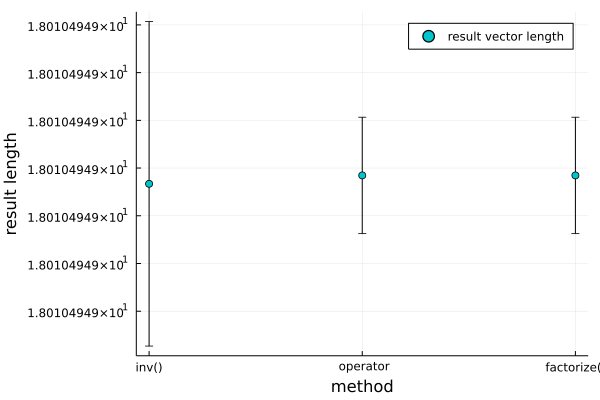

GKS: Possible loss of precision in routine SET_WINDOW


In [6]:
scatter(df.method, df.result_length, size = (600, 400), yerr = df.error, legend=:topright, 
    label = "result vector length", color=:turquoise3, xlabel = "method", ylabel = "result length")

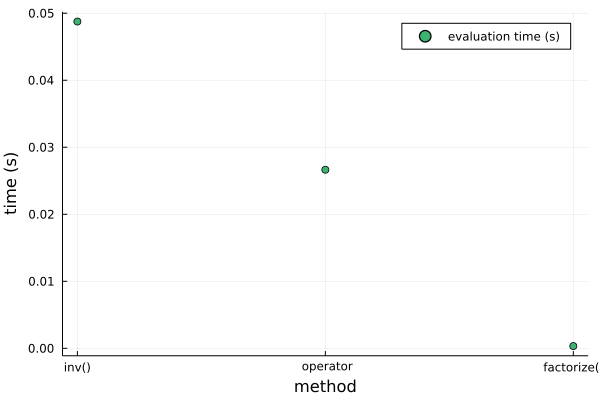

In [7]:
scatter(df.method, df.time, size = (600, 400), legend=:topright, 
    label = "evaluation time (s)", color=:mediumseagreen, xlabel = "method", ylabel = "time (s)")

#### Zadanie 2 (1pkt)
Policz współczynniki wielomianu aproksymującego dowolne dane z poprzednich laboratoriów tworząc wprost układ równań i rozwiązujac go (metoda z użyciem faktoryzacji QR zaprezentowana na tym laboratorium).
Porównaj wyniki z tymi otrzymanymi poprzednio.

In [8]:
# data from lab5 - average matrix multiplication runtime in C
df_ = CSV.read("try.csv", delim=",",DataFrame)
grouped_ = groupby(df_, [:size, :method])
stats_ = combine(grouped_, "time" => mean, "time" => std)
naive = stats_[stats_.method .=="naive" , :]
better = stats_[stats_.method .=="better" , :]
blas = stats_[stats_.method .=="gsl blas" , :]
first(stats_, 5)

,size,method,time_mean,time_std
,Int64,String15,Float64,Float64
1,10,naive,4.1e-6,3.07794e-7
2,10,better,4.05e-6,2.23607e-7
3,10,gsl blas,2.8e-6,8.28823e-6
4,35,naive,0.0001516,3.13404e-6
5,35,better,0.0001561,1.03113e-5


In [9]:
# aproksymacja Polynomials
fit_naive = fit(naive.size, naive.time_mean, 3)
fit_better = fit(better.size, better.time_mean, 3)
fit_blas = fit(blas.size, blas.time_mean, 2)
print()

In [10]:
# faktoryzacja QR
function QR(data, n)
    A = zeros(length(data.size), n+1)          # stworzenie i uzupełnienie macierzy A
    for i=1:n
        A[:, i] = (data.size).^(n-i+1)
    end
    A[:, n+1] = ones(length(data.size))
      
    AF = factorize(A)                                         # faktoryzacja i rozwiązanie układu
    res = AF.R\((Transpose(AF.Q)*(data.time_mean))[1:(n+1)])
    return reverse(res)
end

QR (generic function with 1 method)

In [11]:
qr_naive = QR(naive, 3)
qr_better = QR(better, 3)
qr_blas = QR(blas, 2)
print()

In [12]:
println("Polynomial coeffs: ", fit_naive, "\nQR coeffs: " , qr_naive)

Polynomial coeffs: -0.0429697 + 0.000668837*x - 2.37767e-6*x^2 + 6.41532e-9*x^3
QR coeffs: [-0.04296968415062086, 0.0006688374206132814, -2.377665712155877e-6, 6.41532120954763e-9]


In [13]:
println("Polynomial coeffs: ", fit_better, "\nQR coeffs: " , qr_better)

Polynomial coeffs: -0.00205716 + 5.05738e-6*x + 9.3084e-9*x^2 + 3.32925e-9*x^3
QR coeffs: [-0.0020571620438618425, 5.057382412148646e-6, 9.308404576015377e-9, 3.3292523294895486e-9]


In [14]:
println("Polynomial coeffs: ", fit_blas, "\nQR coeffs: " , qr_blas)

Polynomial coeffs: 0.0270595 - 0.000325349*x + 7.83348e-7*x^2
QR coeffs: [0.027059545246232244, -0.00032534883495232136, 7.833477308452912e-7]


#### Zadanie 3 (2 pkt)

Znajdź i zaprezentuj działanie innego zastosowania wybranej faktoryzacji. Przykładowe (ale nie jedyne!) tematy:

-    tworzenie pseudoinversji macierzy (http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-macausland-pseudo-inverse-present.pdf).

-   uzycie faktoryzacji QR do znajdowania wartości własnych (https://en.wikipedia.org/wiki/QR_algorithm)

-  zastosowanie faktoryzacji SVD - np. zastosowania w uczeniu maszynowym 


Użycie faktoryzacji QR do znajdowania wartości własnych

Algorytm QR:
<br /> $A_{0} = A$ <br />
dopóki $A_{n}$ nie jest górna-trójkątna:  
$A_k = Q_kR_k$  
$A_{k+1} = R_kQ_k$

$A_k$ są podobne więc mają te same wartości własne.
$A_k$ zbiegają do macierzy trójkątnej, dla której wartości własne znajdują się na przekątnej

In [15]:
function is_triangular(A)
    for i = 1:(size(A, 1))
        for j = 1:(i-1)
            if A[i, j] != 0
                return false
            end
        end
    end
    return true
end     

is_triangular (generic function with 1 method)

In [16]:
A = rand(3, 3)

3×3 Matrix{Float64}:
 0.135993  0.899225   0.857573
 0.747117  0.881286   0.7514
 0.059631  0.0728165  0.659204

In [17]:
is_triangular(A)

false

In [18]:
B = [1 2 3; 0 4 5; 0 0 6]

3×3 Matrix{Int64}:
 1  2  3
 0  4  5
 0  0  6

In [19]:
is_triangular(B)

true

In [20]:
function algorithmQR(A)
    Ak = A
    while(!is_triangular(Ak))
        (Q, R) = qr(Ak)
        Ak = R*Q
    end
    return Ak
end

algorithmQR (generic function with 1 method)

In [21]:
A = [1 2 3; 4 5 6; 7 8 9]

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

In [22]:
Ak = algorithmQR(A)

3×3 Matrix{Float64}:
 16.1168  -4.89898   3.72892e-15
  0.0     -1.11684   7.23512e-16
  0.0      0.0      -3.62597e-16

In [23]:
# wartości z przekątnej Ak
diag(Ak)

3-element Vector{Float64}:
 16.116843969807036
 -1.1168439698070443
 -3.625973214694716e-16

In [24]:
# prawdziwe wartości własne - funkcja z Julii
eigvals(Ak)

3-element Vector{Float64}:
 -1.1168439698070443
 -3.625973214694716e-16
 16.116843969807036